## Transfer Learning InceptionV3 using Keras

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
# import the libraries as shown below

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, load_model, Sequential 
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import numpy as np
import itertools
import keras

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '../data/train'
val_path = '../data/val'


In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
import tensorflow
inceptionv3 =tensorflow.keras.applications.InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in inceptionv3.layers:
    layer.trainable = False

In [ ]:
  # useful for getting number of output classes
folders = glob('../data/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(inceptionv3.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
my_model = Model(inputs=inceptionv3.input, outputs=prediction)

In [ ]:

# view the structure of the model
my_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [ ]:
from keras.optimizers import Adam

opt = Adam(lr=0.0001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0,  amsgrad=False)

In [ ]:
# tell the model what cost and optimization method to use
my_model.compile(
  loss='categorical_crossentropy',
  optimizer = opt,
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, 
                             rotation_range=10,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             shear_range = 0.2, 
                             vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 6024 images belonging to 4 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            shuffle = False,
                                            class_mode = 'categorical')

Found 1506 images belonging to 4 classes.


In [ ]:
# ReduceLROnPlateau - automatically set the LR if no change is detected
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                             patience = 3, 
                                             verbose = 1, 
                                             factor = 0.5, 
                                             min_lr = 0.00001)

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
model_history = my_model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  callbacks = [learning_rate_reduction],
  steps_per_epoch = len(training_set),
  validation_steps = len(test_set)  
)

Epoch 1/50
189/189 [==============================] - 1241s 6s/step - loss: 0.7116 - accuracy: 0.7213 - val_loss: 0.3027 - val_accuracy: 0.8831
Epoch 2/50
189/189 [==============================] - 78s 412ms/step - loss: 0.2710 - accuracy: 0.8983 - val_loss: 0.2065 - val_accuracy: 0.9263
Epoch 3/50
189/189 [==============================] - 78s 411ms/step - loss: 0.2087 - accuracy: 0.9187 - val_loss: 0.2009 - val_accuracy: 0.9210
Epoch 4/50
189/189 [==============================] - 77s 410ms/step - loss: 0.1853 - accuracy: 0.9284 - val_loss: 0.2143 - val_accuracy: 0.9163
Epoch 5/50
189/189 [==============================] - 78s 410ms/step - loss: 0.1621 - accuracy: 0.9375 - val_loss: 0.1541 - val_accuracy: 0.9456
Epoch 6/50
189/189 [==============================] - 77s 409ms/step - loss: 0.1575 - accuracy: 0.9423 - val_loss: 0.1698 - val_accuracy: 0.9336
Epoch 7/50
189/189 [==============================] - 77s 409ms/step - loss: 0.1426 - accuracy: 0.9464 - val_loss: 0.1569 - val_acc

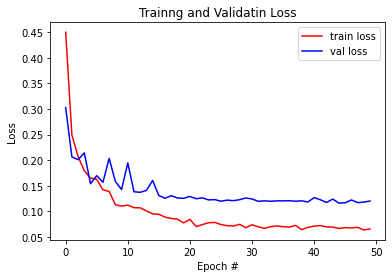

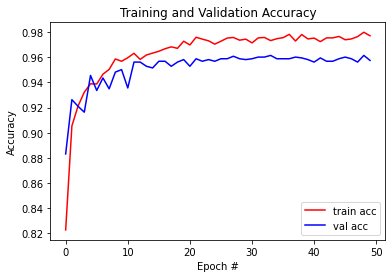

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(model_history.history['loss'],'r', label='train loss')
plt.plot(model_history.history['val_loss'],'b', label='val loss')
plt.title("Trainng and Validatin Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(model_history.history['accuracy'],'r', label='train acc')
plt.plot(model_history.history['val_accuracy'],'b', label='val acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#loss, accuracy = my_model.evaluate(x_test, y_test, verbose=1)
loss, accuracy = my_model.evaluate(test_set, verbose=1)
# loss_v, accuracy_v = my_model.evaluate(x_validate, y_validate, verbose=1)
t_loss, t_accuracy = my_model.evaluate(training_set, verbose=1)

189/189 [==============================] - 72s 380ms/step - loss: 0.0682 - accuracy: 0.9773


In [ ]:
print("Training: accuracy = %f  ;  loss_v = %f" % (t_accuracy, t_loss))
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.977258  ;  loss_v = 0.068196
Validation: accuracy = 0.957503  ;  loss = 0.120334


In [ ]:
# save it as a h5 file
my_model.save('../models/faba_bean_model_inceptionv3.h5')

In [ ]:
# open saved model file
my_model = keras.models.load_model('../models/faba_bean_model_inceptionv3.h5')

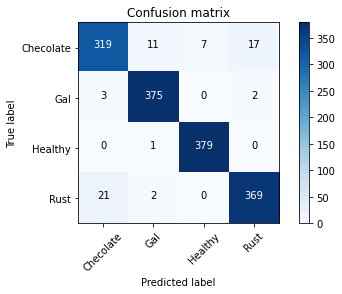

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get the predicted classes
predictions = my_model.predict(test_set,  1506 // 32 + 1)
predicted_classes = np.argmax(predictions, axis = 1) 

# Get ground-truth classes and class-labels
true_classes = test_set.classes

target_name = ['Checolate', 'Gal', 'Healthy', 'Rust']

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plot_confusion_matrix(confusion_mtx, classes = target_name) 

Text(0, 0.5, 'Fraction classified incorrectly')

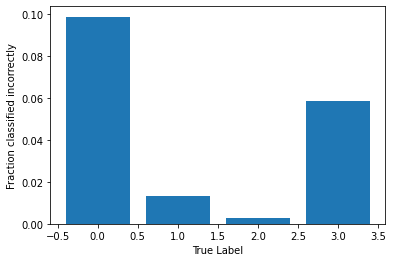

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(4),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [ ]:
print('\nClassification Report\n')
target_name = ['Checolate_spot', 'gal', 'healthy', 'rust']
report = classification_report(true_classes, predicted_classes, target_names=target_name)
print(report)


Classification Report

                precision    recall  f1-score   support

Checolate_spot       0.93      0.90      0.92       354
           gal       0.96      0.99      0.98       380
       healthy       0.98      1.00      0.99       380
          rust       0.95      0.94      0.95       392

      accuracy                           0.96      1506
     macro avg       0.96      0.96      0.96      1506
  weighted avg       0.96      0.96      0.96      1506

